# Standard imports

In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import HpAlgorithms
import HpMLUtils
import HpMLPlots
import HpHyperParameterOptimisation
import HpTrainingFrame

In [4]:
df_mc=pd.read_hdf('/eos/user/j/jglatzer/L2Output_R20_Nov_v2_pandaspython3/pandas_INC_ge6jge4b.h5', 'INC_ge6jge4b')

# Prepare data for parameterised H+ classification

split into test and training data

In [5]:
htf=HpTrainingFrame.HpTrainingFrame(df_mc)
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass="multi",addMass=True)
print(X_train.columns, X_train.shape)

Index(['nJets', 'nBTags_70', 'pT_jet1', 'Mbb_MindR_70', 'pT_jet5', 'H1_all',
       'dRbb_avg_70', 'dRlepbb_MindR_70', 'Muu_MindR_70', 'HT_jets',
       'Mbb_MaxPt_70', 'Mbb_MaxM_70', 'Mjjj_MaxPt', 'Centrality_all',
       'hpmass'],
      dtype='object') (235995, 15)


In [6]:
HpMLUtils.summarizeFitData(X_train, y_train,w_train, categories=X_train.hpmass, showavevarminmax=False)

X.shape= (235995, 15) y.shape= (235995,)
w.shape= (235995,)

columns= Index(['nJets', 'nBTags_70', 'pT_jet1', 'Mbb_MindR_70', 'pT_jet5', 'H1_all',
       'dRbb_avg_70', 'dRlepbb_MindR_70', 'Muu_MindR_70', 'HT_jets',
       'Mbb_MaxPt_70', 'Mbb_MaxM_70', 'Mjjj_MaxPt', 'Centrality_all',
       'hpmass'],
      dtype='object')
categories= [-1, 200, 225, 250, 275, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]

sum of weights per category
       all 2627.7878701014624
        -1 1773.1918984370175
       200 103.25055362269731
       225 139.41190725846948
       250 140.77163076529945
       275 127.89850805160341
       300 111.59172096685447
       350 84.23831982536186
       400 64.2254739452055
       500 35.552147119629055
       600 20.4739117537052
       700 11.982341892420514
       800 6.982210934992669
       900 4.238406393684131
      1000 2.4718073416139097
      1200 0.9239538781114109
      1400 0.3568699933922498
      1600 0.1409585910351725

ok the columns include the H+ mass now

Now on to scaling the weights to have a flat distributiong in H+ mass

In [8]:
sb=HpMLUtils.MultiSBWeightsScaler(backgroundclass=-1)
sb.fit(X_train,X_train.hpmass, sample_weight=w_train)
X_train=sb.transform(X_train,X_train.hpmass, sample_weight=w_train)
w_train.groupby(X_train.hpmass).sum()

hpmass
-1       0.500000
 200     0.006536
 225     0.006536
 250     0.006536
 275     0.006536
 300     0.009804
 350     0.013072
 400     0.019608
 500     0.026144
 600     0.026144
 700     0.026144
 800     0.026144
 900     0.026144
 1000    0.039216
 1200    0.052288
 1400    0.052288
 1600    0.052288
 1800    0.052288
 2000    0.052288
Name: weight, dtype: float64

now set the hpmass for the background correctly (same PDF as signal)

In [10]:
from scipy.stats import rv_discrete

signalsum=w_train[X_train.hpmass>0].sum()
xk=[]
pk=[]
for name, group in w_train.groupby(X_train.hpmass):
    if name>0:
        xk.append((-1)*name)
        pk.append(group.sum()/signalsum)
#print xk,pk
custm=rv_discrete(values=(xk,pk))
#print "before resetting hpmass", sorted(X_train.hpmass.unique())
X_train["hpmass"]=X_train.hpmass.apply(lambda x: x if x>0 else custm.rvs())
#print "resetting hpmass", sorted(X_train.hpmass.unique())

print("the following is the difference between + and - mass")
print((w_train*((X_train.hpmass>0)-0.5)*2).groupby(X_train.hpmass.abs()).sum())
print("the following is the sum of weights")
print(w_train.groupby(X_train.hpmass).sum())

X_train.hpmass=X_train.hpmass.abs()

the following is the difference between + and - mass
hpmass
200    -0.000985
225    -0.000174
250    -0.000606
275     0.000294
300    -0.000096
350     0.000481
400     0.000373
500     0.001837
600    -0.000702
700    -0.001597
800    -0.002995
900    -0.002788
1000    0.000984
1200   -0.001435
1400    0.003861
1600   -0.001357
1800    0.004081
2000    0.000825
dtype: float64
the following is the sum of weights
hpmass
-2000    0.051463
-1800    0.048207
-1600    0.053644
-1400    0.048427
-1200    0.053722
-1000    0.038232
-900     0.028932
-800     0.029138
-700     0.027741
-600     0.026846
-500     0.024307
-400     0.019235
-350     0.012591
-300     0.009900
-275     0.006242
-250     0.007142
-225     0.006710
-200     0.007521
 200     0.006536
 225     0.006536
 250     0.006536
 275     0.006536
 300     0.009804
 350     0.013072
 400     0.019608
 500     0.026144
 600     0.026144
 700     0.026144
 800     0.026144
 900     0.026144
 1000    0.039216
 1200    0.052288


## Training the classifier

In [11]:
clf=HpAlgorithms.getGradientBDTClassifier(options = {'n_estimators': 200, 'learning_rate': 0.1}) #let's get away from the default trees to get a better performance

let's have a quick look if those parameters are roughly ok for mH+=800 GeV

In [12]:
def prepareTestDS(hpmass,X_test,y_test,w_test):
    mask=(X_test.hpmass==hpmass) | (X_test.hpmass<=0)
    X_new=X_test.copy()
    X_new["hpmass"]=hpmass
    return X_new[mask], y_test[mask], w_test[mask]
print(sorted(X_test.hpmass.unique()))

[-1, 200, 225, 250, 275, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]


Training for  200
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDTval_n_estimators_criterionfriedman_mse_initNone_learning_rate01_lossdeviance_max_depth5_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators200_n_iter_no_changeNone_presortauto_random_state0_subsample10_tol00001_validation_fraction01_verbose0_warm_startFalse.png


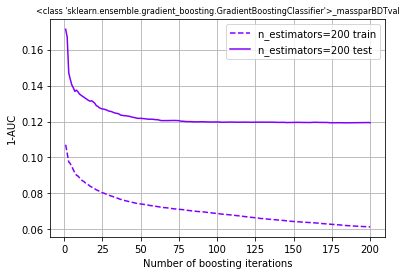

In [14]:
X_test800,y_test800,w_test800=prepareTestDS(800,X_test,y_test,w_test)
opt=HpHyperParameterOptimisation.HpOptimise("massparBDTval",clf,X_train,y_train,w_train,X_test800,y_test800,w_test800)
opt.saveValidationCurve(variable="n_estimators")

Training for  120
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDTval_n_estimators_criterionfriedman_mse_initNone_learning_rate013_lossdeviance_max_depth5_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators120_n_iter_no_changeNone_presortauto_random_state0_subsample10_tol00001_validation_fraction01_verbose0_warm_startFalse.png


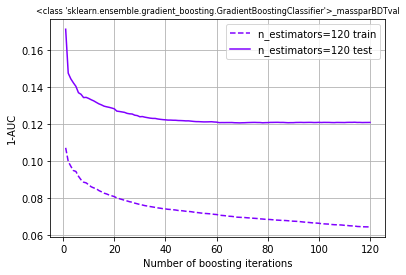

In [15]:
clf=HpAlgorithms.getGradientBDTClassifier(options = {'n_estimators': 120, 'learning_rate': 0.13}) #let's get away from the default trees to get a better performance
X_test800,y_test800,w_test800=prepareTestDS(800,X_test,y_test,w_test)
opt=HpHyperParameterOptimisation.HpOptimise("massparBDTval",clf,X_train,y_train,w_train,X_test800,y_test800,w_test800)
opt.saveValidationCurve(variable="n_estimators")

In [16]:
%time clf.fit(X_train, y_train, sample_weight=w_train)

CPU times: user 1min 30s, sys: 31.8 ms, total: 1min 30s
Wall time: 1min 30s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.13, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.01, n_estimators=120,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [17]:
from joblib import dump
dump(clf, 'massparameterisedBDT.joblib') 

['massparameterisedBDT.joblib']

This is pretty fast now....

## Evaluating the classifier for all H+ masses

In [18]:
hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]

In [20]:
print("1-ROC AUC for different masses in 6j4b - test, train")

trainvalues=[]
testvalues=[]
X_testfilter={}
y_testfilter={}
w_testfilter={}
X_trainfilter={}
y_trainfilter={}
w_trainfilter={}

for hpmass in hpmasses:
    X_trainfilter[hpmass], X_testfilter[hpmass], _, y_trainfilter[hpmass], y_testfilter[hpmass],_, w_trainfilter[hpmass], w_testfilter[hpmass], _=htf.prepare(hpmass=hpmass,addMass=True)
    X_trainfilter[hpmass].hpmass=hpmass
    X_testfilter[hpmass].hpmass=hpmass
  
    opt=HpHyperParameterOptimisation.HpOptimise("massparBDT"+str(hpmass),clf,X_trainfilter[hpmass],y_trainfilter[hpmass],w_trainfilter[hpmass],X_testfilter[hpmass],y_testfilter[hpmass],w_testfilter[hpmass])
    test,train=opt.test(X_trainfilter[hpmass], y_trainfilter[hpmass], w_trainfilter[hpmass], X_testfilter[hpmass], y_testfilter[hpmass], w_testfilter[hpmass])
    trainvalues.append(train)
    testvalues.append(test)

    print(hpmass, test, train)

1-ROC AUC for different masses in 6j4b - test, train
200 0.4011469480916192 0.3644767907829588
225 0.3849203524999285 0.3577502707493533
250 0.3864955410629486 0.3521328750854189
275 0.3763293520377168 0.3447275526246004
300 0.3545841578296772 0.325809739960205
350 0.3351679054407206 0.3091548026001506
400 0.30485595459837267 0.2700961136997314
500 0.2408181536372972 0.22374171119676312
600 0.19507217954115197 0.17671526580526276
700 0.15348591703588998 0.13359804214552307
800 0.1208438797913558 0.10440766711986726
900 0.09521943757425966 0.08654821067066087
1000 0.0804955957725988 0.06788601382150805
1200 0.050919810882050554 0.041390936089027885
1400 0.03673054946239207 0.028688534041148794
1600 0.02756450759422524 0.021054619560335164
1800 0.020744680667706628 0.01449729598142091
2000 0.015146068695355064 0.011350278335399366


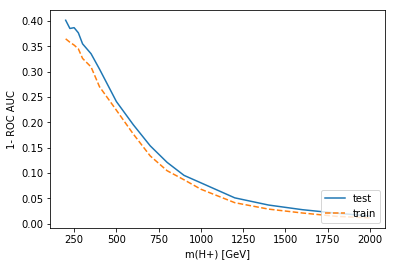

In [21]:
plt.plot(hpmasses, testvalues, '-', label='test')
plt.plot(hpmasses, trainvalues, '--', label='train')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")

There is basically no overtraining --> we can probably win a bit of sensitivity by moving towards a higher number of trees and more depth or lower learning rate

## Optimising the hyperparameters for m(H+)=800 GeV
and hoping it holds independently

In [22]:
X_test800,y_test800,w_test800=prepareTestDS(800,X_test,y_test,w_test)

Validation curve for learning_rate
Training for  0.05
Training for  0.1
Training for  0.13
Training for  0.2
Training for  0.5
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDT800_learning_rate_criterionfriedman_mse_initNone_learning_rate05_lossdeviance_max_depth5_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators120_n_iter_no_changeNone_presortauto_random_state0_subsample10_tol00001_validation_fraction01_verbose0_warm_startFalse.png
Validation curve for max_depth
Training for  3
Training for  4
Training for  5
Training for  6
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDT800_max_depth_criterionfriedman_mse_initNone_learning_rate05_lossdeviance_max_depth6_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators120_n_iter_no_changeNon

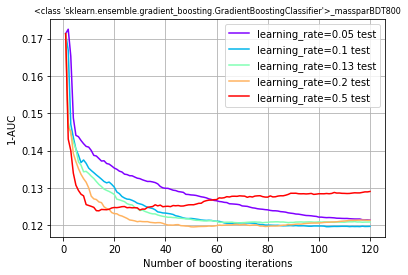

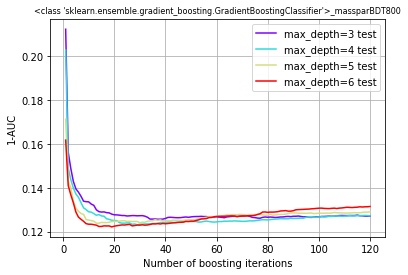

In [23]:
hpopt=HpHyperParameterOptimisation.HpOptimise("massparBDT800",clf,X_train,y_train,w_train,X_test800,y_test800,w_test800)
hpopt.saveAllValidationCurves()

## Training the classifier at N-1 masses and checking at the remaining mass

In [24]:
from scipy.stats import rv_discrete
sb=HpMLUtils.MultiSBWeightsScaler(backgroundclass=-1)

trainvalues_cross=[]
testvalues_cross=[]
for hpmass in hpmasses:
    X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass, addMass=True, invertsignal=True)
    sb.fit(X_train,X_train.hpmass, sample_weight=w_train)
    X_train=sb.transform(X_train,X_train.hpmass, sample_weight=w_train)

    signalsum=w_train[X_train.hpmass>0].sum()
    xk=[]
    pk=[]
    for name, group in w_train.groupby(X_train.hpmass):
        if name>0:
            xk.append((-1)*name)
            pk.append(group.sum()/signalsum)
    
    custm=rv_discrete(values=(xk,pk))
    X_train["hpmass"]=X_train.hpmass.apply(lambda x: x if x>0 else custm.rvs())
    X_train.hpmass=X_train.hpmass.abs()
    
    clf=HpAlgorithms.getGradientBDTClassifier()
    clf.fit(X_train, y_train, sample_weight=w_train)
    #write the results into a file
    dump(clf, 'massparameterisedBDT_allbut'+str(hpmass)+'.joblib')
    
    X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval =htf.prepare(hpmass=hpmass, addMass=True, invertsignal=False)
    
    #X_testfilter[hpmass],y_testfilter[hpmass],w_testfilter[hpmass]=prepareTestDS(hpmass,X_test,y_test,w_test)
    X_test["hpmass"]=hpmass
    X_train["hpmass"]=hpmass
    opt=HpHyperParameterOptimisation.HpOptimise("massparBDT"+str(hpmass),clf,X_train,y_train,w_train,X_test,y_test,w_test)
    test,train=opt.test(X_train, y_train, w_train, X_test, y_test, w_test)
    trainvalues_cross.append(train)
    testvalues_cross.append(test)
    print(hpmass, test, train)

200 0.43673735170651506 0.4126903789815606
225 0.3929722288813289 0.3662028756307024
250 0.3903737298911084 0.36088926473649263
275 0.3673398181907982 0.34151799809989214
300 0.36693701873751605 0.34328259353130564
350 0.33982381404566564 0.31942548885489286
400 0.31554823625273976 0.28225418103895994
500 0.260831640932754 0.24803859750421886
600 0.20511817099909557 0.18987932389170192
700 0.15329476976501588 0.13806379671397173
800 0.12580399151485766 0.11110017676525719
900 0.09727954874565459 0.08744587703757545
1000 0.08134010879804421 0.07000894530030644
1200 0.053418588216892604 0.04341228575117939
1400 0.037481024114641714 0.030620146993082797
1600 0.02797451870706602 0.022414747808154223
1800 0.021555851404670978 0.015339261903437595
2000 0.016534031434481178 0.012269512118769477


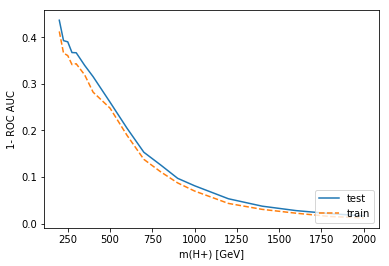

In [25]:
plt.plot(hpmasses, testvalues_cross, '-', label='test')
plt.plot(hpmasses, trainvalues_cross, '--', label='train')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")
plt.show()

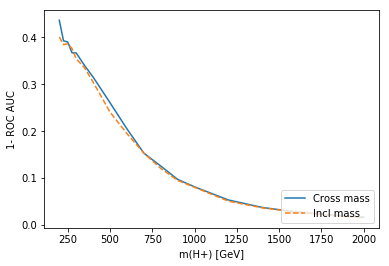

In [26]:
plt.plot(hpmasses, testvalues_cross, '-', label='Cross mass')
plt.plot(hpmasses, testvalues, '--', label='Incl mass')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")
plt.show()

--> It seems that leaving out one mass point in between almost makes no difference (exception: 200 GeV, but that's not really a surprise)

### let's see how this converts to the default BDT

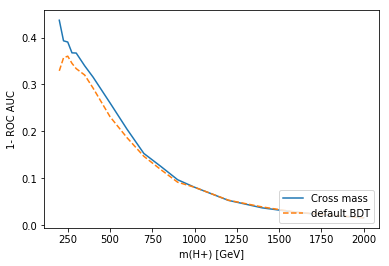

In [27]:
testdefaultBDT=[0.3290841140322679, 0.3566890794845421, 0.3602662115193581, 0.34498428916467183, 0.33375748714257425, 0.32019286312547357, 0.29225728165594855, 0.23146437865390979, 0.18697956512088676, 0.14718158177504637, 0.11895855659790655, 0.09204235231427149, 0.08130798049109356, 0.05375180442290828, 0.039379786382951254, 0.028362194212484093, 0.022254177247589824, 0.0160571366514084]
plt.plot(hpmasses, testvalues_cross, '-', label='Cross mass')
plt.plot(hpmasses, testdefaultBDT, '--', label='default BDT')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")
plt.show()

and how about cross section limit

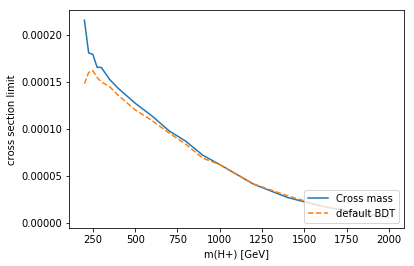

No handles with labels found to put in legend.


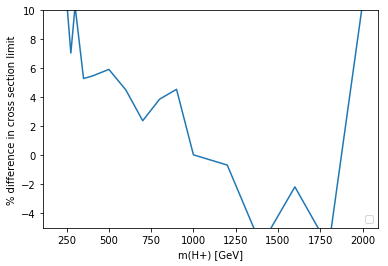

In [28]:
z=[ 5.84983620e-03, -4.16702246e-03,  1.22938606e-03, -1.36789294e-05] #fit values for ROC AUC to cross section limit comparison
f=np.poly1d(z)
plt.plot(hpmasses, f(testvalues_cross), '-', label='Cross mass')
plt.plot(hpmasses, f(testdefaultBDT), '--', label='default BDT')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('cross section limit')
plt.legend(loc="lower right")
plt.show()

#and not %difference
plt.plot(hpmasses, (f(testvalues_cross)/f(testdefaultBDT)-1)*100, '-')
#plt.plot(hpmasses, f(testdefaultBDT), '--', label='default BDT')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('% difference in cross section limit')
plt.legend(loc="lower right")
plt.ylim((-5,10))
plt.show()


one problem with the BDT is probably that the BDT score per event is not exactly smooth (probably quite ok as the distribution should be pretty smooth)

In [29]:
def decisionfunction(eventnumber):
    testmasses=np.linspace(200,2000, 1801)
    line1=X_test.iloc[eventnumber].copy()
    df = pd.DataFrame([line1]*len(testmasses))
    df["hpmass"]=testmasses
    y_pred=clf.decision_function(df)
    y_pred[:5]
    plt.plot(testmasses, y_pred, '-')
    plt.xlabel('m(H+) [GeV]')
    plt.ylabel('BDT score')
    #plt.legend(loc="lower right")
    plt.show()

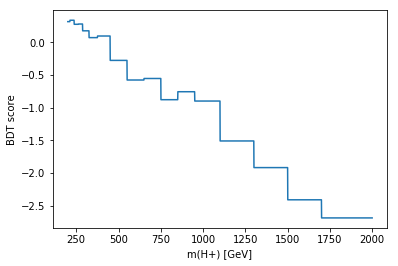

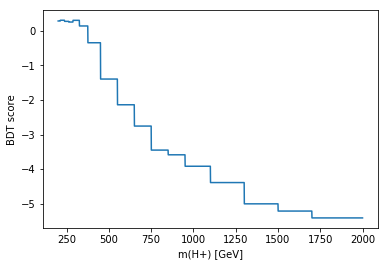

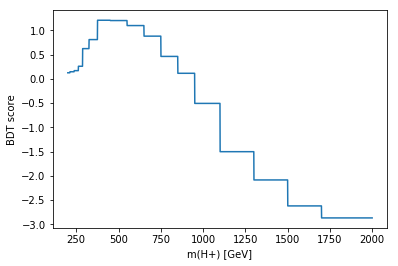

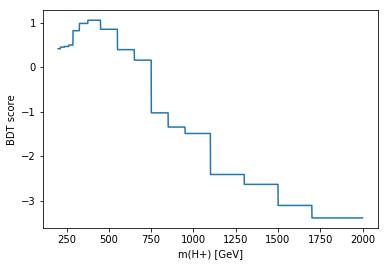

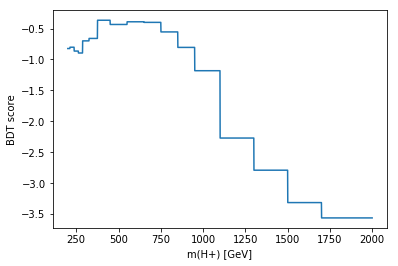

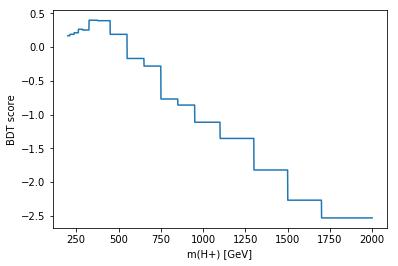

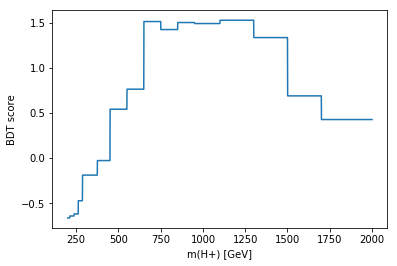

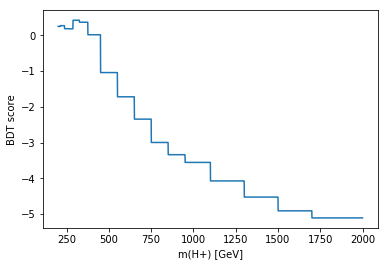

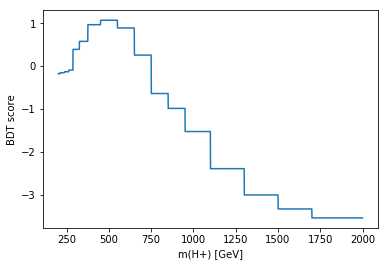

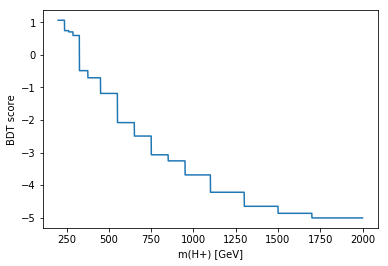

In [30]:
for i in range(0,10):
    decisionfunction(i)